In [87]:
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw
from bw2data import parameters
from sympy.physics.units import years
from sympy.stats.crv_types import LogNormalDistribution
from sympy import init_printing
import lca_algebraic as agb
from dotenv import load_dotenv

# Custom utils defined for the parameterization
from lca_algebraic import *
from lca_algebraic.stats import *

# Pretty print for Sympy
init_printing()

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm, expon, beta, uniform, triang, kstest

In [89]:
BW_PROJECT = 'lca-alg-2' # insert your project name here
bd.projects.set_current(BW_PROJECT)

EI_DB = 'ecoinvent-3.9.1-cutoff' # name of ecoinvent database in your project
# We use a separate DB for defining our foreground model / activities
USER_DB = "MyForeground"

In [90]:
# This is better to cleanup the whole foreground model each time, and redefine it in the notebook (or a python file)
# instead of relying on a state or previous run.
# Any persistent state is prone to errors.
agb.resetDb(USER_DB)

# Parameters are stored at project level : 
# Reset them also
# You may remove this line if you import a project and parameters from an external source (see loadParam(..))
agb.resetParams()

# Overview of the databases
agb.list_databases()

,backend,nb_activities,type
name,,,
biosphere3,sqlite,4718,biosphere
ecoinvent-3.9.1-cutoff,sqlite,21238,background
MyForeground,sqlite,0,foreground


## Define input parameters

lca_algebraic supports 7 distribution types: 
- Fixed: for excluding parameters from the statistical study
- Uniform: uniform distribution within the range of definition
- Triangle: null probability at the boundaries and highest probability for a default value, to be defined within this range. This type of distribution is useful for parameters for which literature only provides a range of extreme values and a usual one.
- Normal: normal distribution, capped to minimum and maximum values
- Log-normal: log-normal distribution, capped to minimum and maximum values
- Beta: beta distribution, capped to minimum and maximum values
- Statistic weight: for discrete parameters: boolean and enum

lca_algebraic supports 3 types of parameters that can be used in the inventory: 
- Float
- Boolean (e.g. discrete parameters, 0 or 1)
- Enumerated: discrete parameters set to one value among a predefined list. They are modeled internally as a linear combination of a set of exclusive boolean parameters

In [91]:
# Example of 'float' parameters
a = agb.newFloatParam(
    'a', 
    default=0.5, min=0.2, max=2,  
    distrib=agb.DistributionType.TRIANGLE, # Distribution type, linear by default
    description="hello world",
    label="extended label for a")

b = agb.newFloatParam(
    'b',
    default=0.5, # Fixed if no min /max provided
    distrib=agb.DistributionType.FIXED,
    description="foo bar")

share_recycled_aluminium = agb.newFloatParam(
    'share_recycled_aluminium',  
    default=0.6, 
    min=0, max=1, std=0.2, 
    distrib=agb.DistributionType.NORMAL, # Normal distrib, with std dev
    description="Share of reycled aluminium")

c = agb.newFloatParam(
    'c',  
    default=0.6, std=0.2, 
    distrib=agb.DistributionType.LOGNORMAL)

beta = agb.newFloatParam(
    'beta',  
    default=0.6, std=0.2, a=2, b=5, 
    distrib=agb.DistributionType.BETA)

In [92]:
# Enum parameters
# Example 'enum' parameter, acting like a switch between several possibilities
# Enum parameters are not Symbol themselves
# They are a facility to represent many boolean parameters at once '<paramName>_<enumValue>' 
# and should be used with the 'newSwitchAct' method 
elec_switch_param = agb.newEnumParam(
    'elec_switch_param', 
    values=["us", "eu"], # If provided as list, all possibilities have te same probability
    default="us", 
    description="Switch on electricty mix")

# Another example enum param
techno_param = agb.newEnumParam(
    'techno_param', 
    values={
        "technoA":0.4, 
        "technoB":0.1,
        "technoC":0.5}, # You can provide a statistical weight for each value, by using a dict
    default="technoA", 
    description="Choice of technology")

In [93]:
# You can define boolean parameters, taking only discrete values 0 or 1
bool_param = agb.newBoolParam(
    'bool_param', 
    default=1)

By default, new parameters are kept in memory but also persisted in the project (unless save=False).

You can persist parameters afterwards with `persistParams()`.

You can load also load parameters from an existing database with `loadParams()`.

The persistance of parameters and the distribution is compatible with **Brightway2** and **Activity Browser**  [see documentation of stat_arrays](https://stats-arrays.readthedocs.io/en/latest/)

In [94]:
# Load parameters previously  persisted in the dabatase.
agb.loadParams()

[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] Variable 'a' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param b was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param b was already defined in '<project>' : overriding.
[WARNING] Variable 'b' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
[WARNING] Variable 'share_recycled_aluminium' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param c was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param c was already defined in '<project>' : overriding.
[WARNING] Variable 'c' was already defined : overiddin

lca_algebraic supports several foreground / background datasets. Background datasets are considered static / non parametrized by the library : they use standard LCA method of **Brightway2**. 

Foreground databases are considered parametric and their activities are developped as functions of parameters and background activities.

In [95]:
agb.setForeground(USER_DB)
agb.list_databases()

,backend,nb_activities,type
name,,,
biosphere3,sqlite,4718,biosphere
ecoinvent-3.9.1-cutoff,sqlite,21238,background
MyForeground,sqlite,0,foreground


In [60]:
# Save database and parameters as Bzipped JSON
#agb.export_db(USER_DB, "data/db.bw2")

In [61]:
# Reimport DB
#agb.import_db("data/db.bw2")

[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] Variable 'a' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param b was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param b was already defined in '<project>' : overriding.
[WARNING] Variable 'b' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
[WARNING] Variable 'share_recycled_aluminium' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param c was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param c was already defined in '<project>' : overriding.
[WARNING] Variable 'c' was already defined : overiddin

Brightway2 SQLiteBackend: MyForeground

A foreground database can be "frozen" to be used as a background database for a specific scenario : the parametrized amounts in the exhanges are computed for a given configuration of the parameters, and replaced by their value. The formulas are still stored in the database and not lost : the database can still be used as a foreground database until its status is changed with `setBackground(...)`.

In [128]:
agb.freezeParams(
    USER_DB, # Name of database to freeze
    
    a=1, b=2) # custom parameter values

[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6


Freezing 'total_inventory' (kg, GLO, None) // first foreground activity : a + 5*b + 1 => 12.00
Freezing 'total_inventory' (kg, GLO, None) // Aluminium 2 : 3*share_recycled_aluminium => 1.80
Freezing 'total_inventory' (kg, GLO, None) // aluminium alloy production, AlMg3 : 0.4*a => 0.40
Freezing 'elect mix' (kilowatt hour, GLO, None) // market group for electricity, medium voltage : elec_switch_param_us => 1.00
Freezing 'elect mix' (kilowatt hour, GLO, None) // market group for electricity, medium voltage : 0.8*elec_switch_param_eu => 0.00
Freezing 'elect mix' (kilowatt hour, GLO, None) // market group for electricity, medium voltage : elec_switch_param_us => 1.00
Freezing 'elect mix' (kilowatt hour, GLO, None) // market group for electricity, medium voltage : 0.8*elec_switch_param_eu => 0.00
Freezing 'Aluminium 2' (kilogram, RER, None) // aluminium, cast alloy : 0.965 - 0.965*share_recycled_aluminium => 0.39
Freezing 'first foreground activity' (kg, GLO, None) // Occupation, industrial 

# Link to background activities and creation of new activities

We provide two functions for easy and fast (indexed) search of activities in reference databases : 
* **findBioAct** : Search activity in **biosphere3** db
* **findTechAct** : Search activity in **ecoinvent** db

Those methods are **faster** and **safer** than using traditionnal "list-comprehension" search : 
They will **fail with an error** if **more than one activity** matches, preventing the model to be based on a random selection of one activity.

The model is defined as a nested combination of background activities with amounts. Amounts are defined either as constant float values or algebric formulas implying the parameters defined above.

## Existing activities

In [98]:
# Biosphere activities
ground_occupuation = agb.findBioAct('Occupation, industrial area') # Search by name
heat = agb.findBioAct('Heat, waste', categories=['air']) # Add category selector

# Technosphere activities

# You can add an optionnal location selector
alu = agb.findTechAct("aluminium alloy production, AlMg3", loc="RER")
alu_scrap = agb.findTechAct('aluminium scrap, new, Recycled Content cut-off')

# Elec 
eu_elec = agb.findTechAct("market group for electricity, medium voltage", 'ENTSO-E')
us_elec = agb.findTechAct("market group for electricity, medium voltage", 'US')

chromium = agb.findTechAct("market for chromium oxide, flakes")

## New activities

In [99]:
# Create a new activity
activity1 = agb.newActivity(USER_DB, # We define foreground activities in our own DB
    "first foreground activity", # Name of the activity
    "kg", # Unit
    exchanges= { # We define exhanges as a dictionarry of 'activity : amount'
        ground_occupuation:3 * b, # Amount can be a fixed value 
        heat: b + 0.2  # Amount can be a Sympy expression (any arithmetic expression of Parameters)
    })

# You can create a virtual "switch" activity combining several activities with an Enum parameter
elec_mix = agb.newSwitchAct(USER_DB, 
    "elect mix", # Name
    elec_switch_param, # Sith parameter
    { # Dictionnary of enum values / activities
        "us" : us_elec, # By default associated amount is 1
        "eu" : (eu_elec, 0.8)  # You can also provide custom amout or formula with a tuple 
    })

## Copy activities

In [100]:
# Copy and update existing activity
alu2 = agb.copyActivity(
    USER_DB, # The copy of a background activity is done in our own DB, so that we can safely update it                
    alu, # Initial activity : won't be altered
    "Aluminium 2") # New name

# Update exchanges by their name 
alu2.updateExchanges({
    
    # Update amount : the special symbol *old_amount* references the previous amount of this exchange
    "aluminium, cast alloy": agb.old_amount * (1 - share_recycled_aluminium),
    
    # Update input activity. Note also that you can use '*' wildcard in exchange name
    "electricity*": elec_mix,
    
    # Update both input activity and amount. 
    # Note that you can use '#' for specifying the location of exchange (useful for duplicate exchange names)
    "chromium#GLO" : dict(amount=4.0, input=chromium)
}) 

# Add exchanges 
alu2.addExchanges({alu_scrap :  12})

## Final inventory

In [101]:
# we define our final model 
total_inventory = agb.newActivity(USER_DB, "total_inventory", "kg", {
    activity1 : b * 5 + a + 1, # Reference the activity we just created
    alu2: 3 * share_recycled_aluminium, 
    alu:0.4 * a})

In [102]:
#Alternatively, you may not define the model again, but load it from the USER DB.
activity1 = agb.findActivity("first foreground activity", db_name=USER_DB)
total_inventory = agb.findActivity("total_inventory", db_name=USER_DB)
alu2 = agb.findActivity("Aluminium 2", db_name=USER_DB)

In [103]:
agb.printAct(activity1) 

first foreground activity (1.000000 kg)           \
                                                              input   amount   
Heat, waste                                             Heat, waste  b + 0.2   
Occupation, industrial area             Occupation, industrial area      3*b   

                                                
                                          unit  
Heat, waste                          megajoule  
Occupation, industrial area  square meter-year

In [104]:
agb.printAct(total_inventory)


total_inventory (1.000000 kg)  \
                                                                    input   
Aluminium 2                                          Aluminium 2[RER]{FG}   
aluminium alloy production, AlMg3  aluminium alloy production, AlMg3[RER]   
first foreground activity                   first foreground activity{FG}   

                                                                         
                                                       amount      unit  
Aluminium 2                        3*share_recycled_aluminium  kilogram  
aluminium alloy production, AlMg3                       0.4*a  kilogram  
first foreground activity                         a + 5*b + 1        kg

In [105]:
# You can also compute amounts by replacing parameters with a float value 
agb.printAct(activity1, b=1.5)

first foreground activity (1.000000 kg)  \
                                                              input   
Heat, waste                                             Heat, waste   
Occupation, industrial area             Occupation, industrial area   

                                                                  
                                       amount               unit  
Heat, waste                  1.70000000000000          megajoule  
Occupation, industrial area  4.50000000000000  square meter-year

In [106]:
# You can print several activities at once to compare them
agb.printAct(alu, alu2)

# Impact calculation

In [107]:
# List of impacts to consider
impacts = agb.findMethods("climate change", mainCat="EF v3.0")
impacts

[('EF v3.0', 'climate change', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)'),
 ('EF v3.0',
  'climate change: land use and land use change',
  'global warming potential (GWP100)')]

In [108]:
# Definition of FU, which can be parametrized
functional_value = a + 5

In [109]:
agb.list_databases()


,backend,nb_activities,type
name,,,
biosphere3,sqlite,4718,biosphere
ecoinvent-3.9.1-cutoff,sqlite,21238,background
MyForeground,sqlite,5,foreground


## Simple first

In [110]:
agb.compute_impacts(
    
    # Root activity of our inventory
    total_inventory, 
    
    # list of impacts to consider
    impacts, 
    
    # The impacts will be divided by the functional unit
    functional_unit=functional_value,
    
    # Parameters of the model
    a=1.0,
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq]
total_inventory,6.49388,0.0143757,6.47352,0.00598768


In [111]:
# You can compute several LCAs at a time and compare them:
agb.compute_impacts(
    [alu, alu2], # The models
    
    impacts, # Impacts
    
    # Parameters of the model
    share_recycled_aluminium=0.3,
    elec_switch_param="us")

[INFO] Db changed recently, clearing cache expr


,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq]
"aluminium alloy production, AlMg3[RER]",7.30938,0.0158928,7.2762,0.0172852
Aluminium 2[RER],30.5997,0.0676298,30.5064,0.0256945


## Fast computation for millions of separate samples

In [112]:
# Fast computation for millions of separate samples
agb.compute_impacts(
    total_inventory, # The model 
    impacts, # Impacts
    functional_unit = functional_value,
    
    # Parameters of the model
    a=list(range(1, 100000)), # All lists should have the same size
    share_recycled_aluminium=1, # Those parameters are fixed
    elec_switch_param="eu")

,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq]
a,,,,
1,13.6403,0.0323597,13.5989,0.00906543
2,12.1094,0.028645,12.072,0.00875809
3,10.9612,0.025859,10.9268,0.00852759
4,10.0681,0.0236922,10.0361,0.00834831
5,9.35367,0.0219587,9.32351,0.00820489
...,...,...,...,...
99995,2.92439,0.00635869,2.91112,0.00691421
99996,2.92439,0.00635869,2.91112,0.00691421
99997,2.92439,0.00635869,2.91112,0.00691421


## Split impacts

It is possible to **tag** activities and then ventilate the impacts according to the value of this "tag".
This is useful to split impact by *phase* or *sub module*.

In [113]:
# Tag activities with a custom attribute : 'phase' in this case
alu2.updateMeta(phase= "phase a")
activity1.updateMeta(phase= "phase b")

In [114]:
# Provide the name of the custom attribute as 'axis', the impacts are split between those
agb.compute_impacts(
    total_inventory, # The model
    impacts, # Impacts
    
    functional_unit = functional_value,
    axis="phase",

    
    # Parameters
    a=1.0,
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia


,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq]
phase,,,,
_other_,0.487292,0.00105952,0.48508,0.00115235
phase_a,6.00659,0.0133162,5.98844,0.00483533
phase_b,0,0,0,0
*sum*,6.49388,0.0143757,6.47352,0.00598768


# Sensitivity analysis



## OAT

 Shows a **matrix of impacts x parameters** colored according to the variation of the impact in the bounds of the parameter.

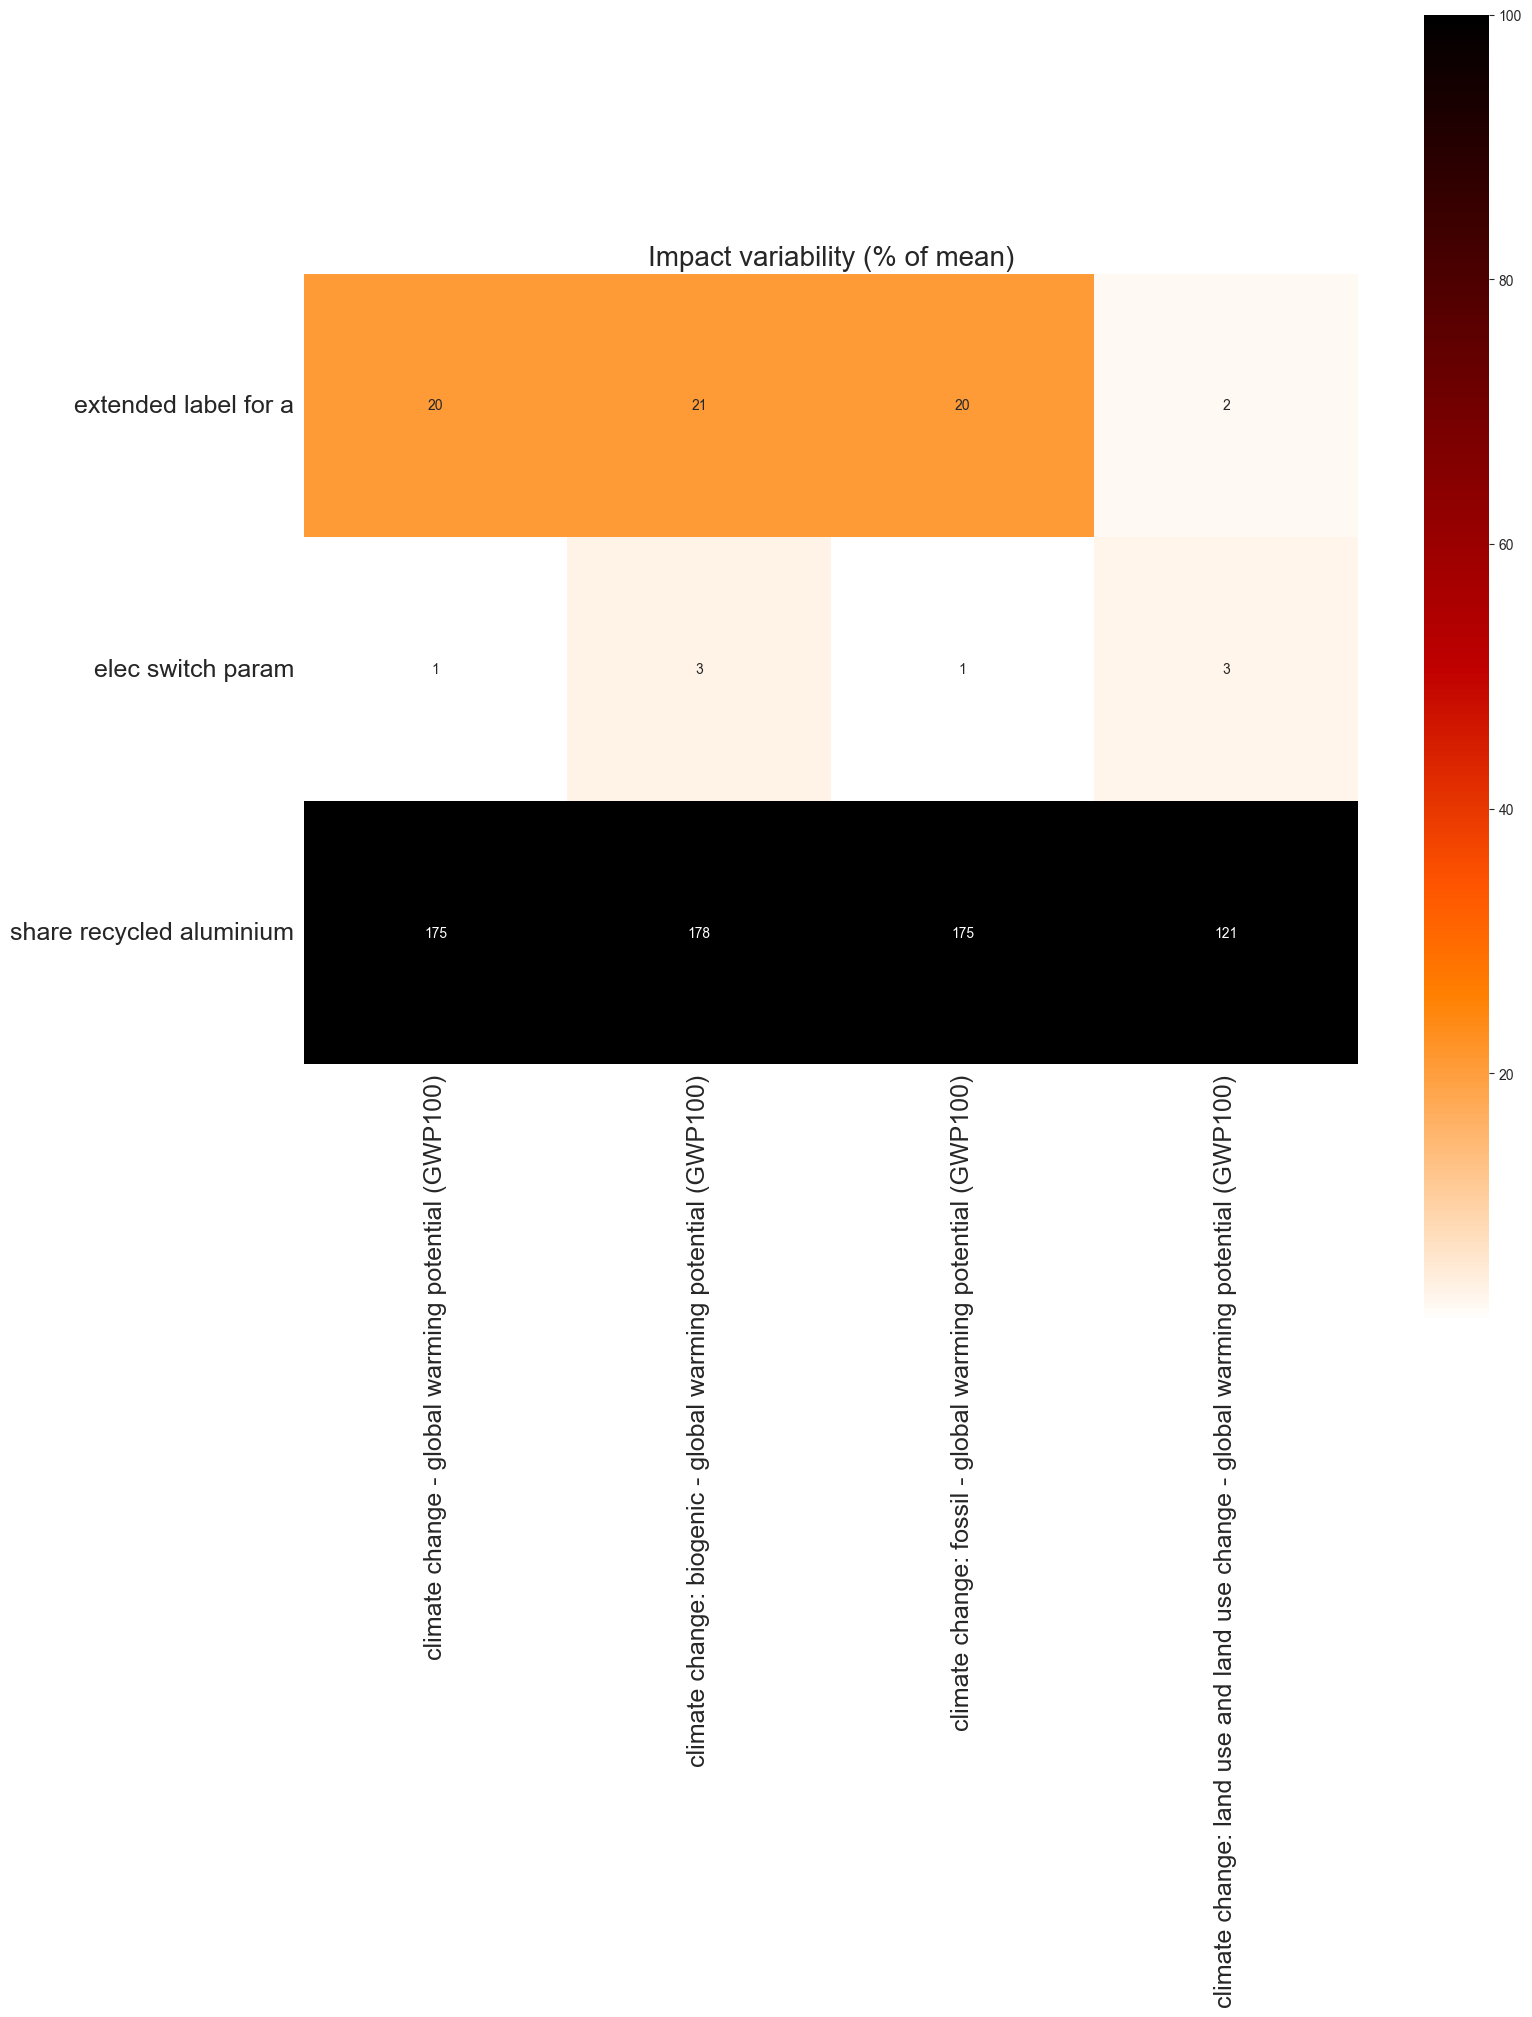

In [115]:
agb.oat_matrix(
    total_inventory, 
    impacts, 
    functional_unit=functional_value)

This functions draws a dashboard showing :
* A dropdown list, for choosing a parameter
* Several graphs of evolution of impacts for this parameter
* Full table of data
* A graph of "bars" representing the variation of each impact for this parameter (similar to the information given in oat_matrix) 

In [117]:
agb.oat_dashboard(
    total_inventory, 
    impacts, 
    functional_unit=functional_value,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True)

interactive(children=(Dropdown(description='param', options=('elec_switch_param', 'share_recycled_aluminium', …

This method shows some limitations though: it does not provide a quantified assessment of the variance of the impacts, and it may hide the importance of some parameters, only revealed when combined with different setups of the other parameters.

## GSA with Monte-Carlo methods and Sobol indices

Similar to OAT matrix, we compute Sobol indices. they represent the ratio between the variance due to a given parameter and the total variance.

for easier comparison, we translate those relative sobol indices into "deviation / mean" importance :

$$RelativeDeviation = \frac{\sqrt{sobol(param) \times totalVariance(impact))}}{mean(impact)}$$


In [118]:
# Show sobol indices 
agb.incer_stochastic_matrix(
    total_inventory, 
    impacts, 
    functional_unit=functional_value)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('EF v3.0', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: land use and land use change', 'global warming potential (GWP100)')


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


interactive(children=(Dropdown(description='indice', options=('s1', 'st'), value='s1'), Dropdown(description='…

We provide a dashboard showing **violin graphs** : the exact probabilistic distribution for each impact. Together with medians of the impacts.

We provide a dashboard showing **violin graphs** : the exact probabilistic distribution for each impact. Together with medians of the impacts.

[WARNING] Param 'b' is marked as FIXED, but passed in parameters : ignored


Generating samples ...
Transforming samples ...


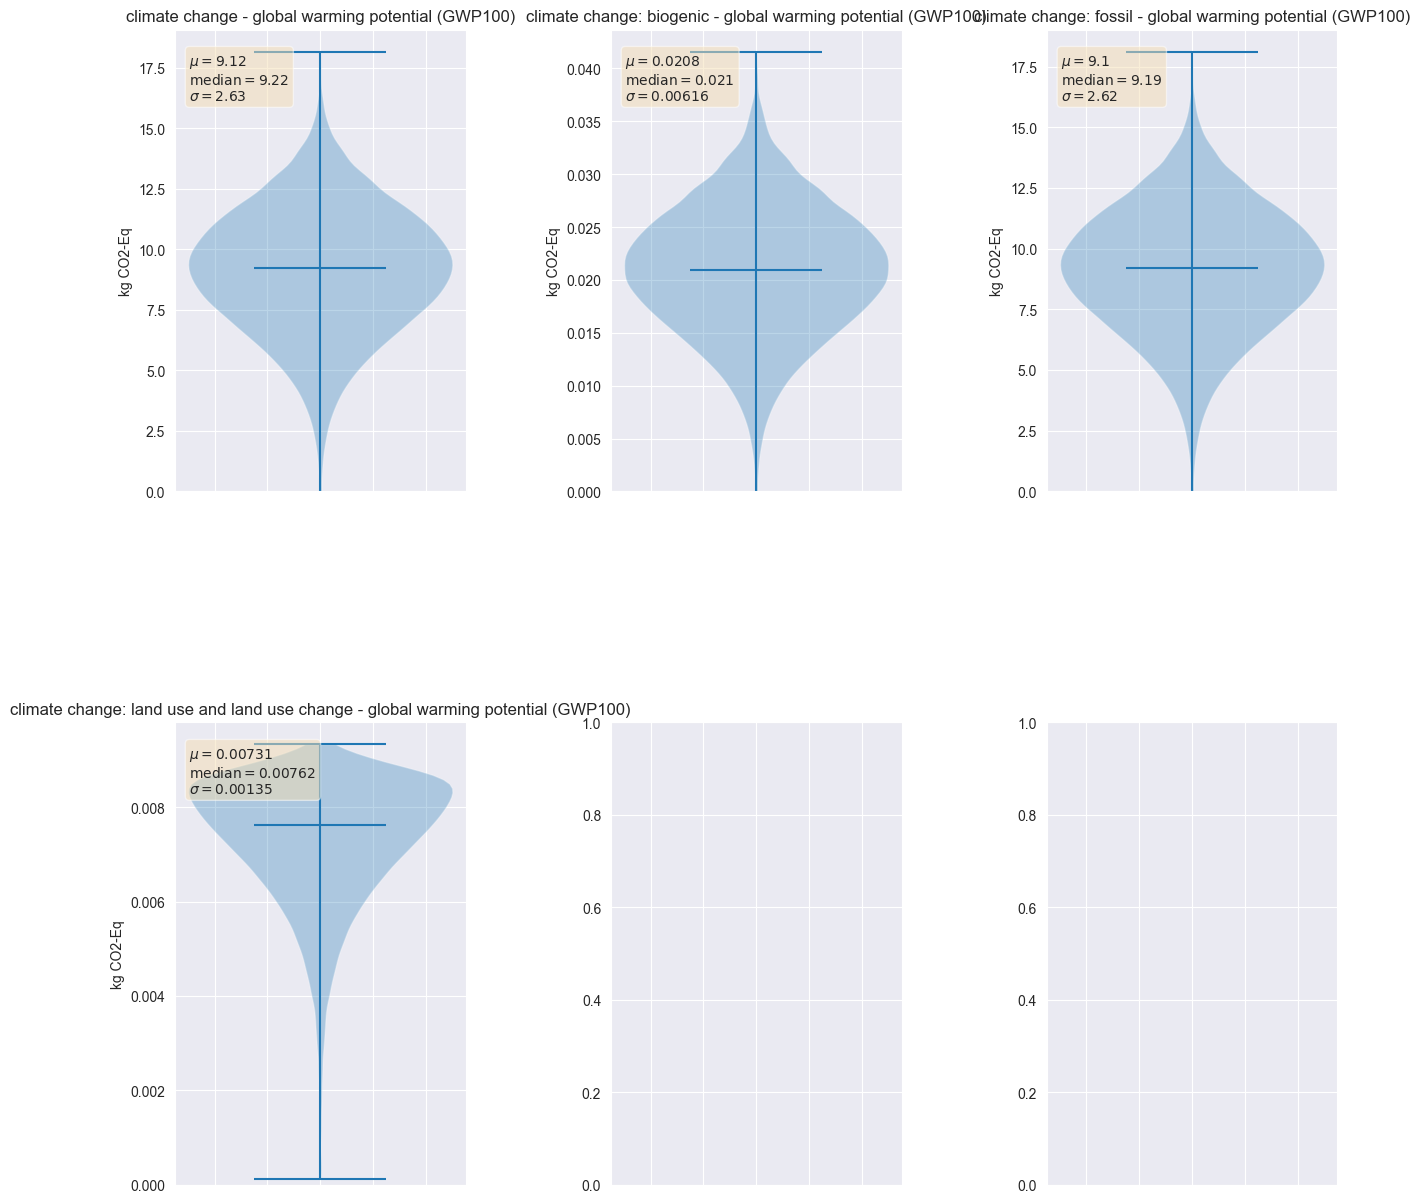

In [119]:
agb.incer_stochastic_violin(
    total_inventory, impacts,
    functional_unit=functional_value,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True, 
    nb_cols=3)

Generating samples ...
Transforming samples ...


[WARNING] Param 'b' is marked as FIXED, but passed in parameters : ignored


,climate change - global warming potential (GWP100) [kg CO2-Eq / ],climate change: biogenic - global warming potential (GWP100) [kg CO2-Eq / ],climate change: fossil - global warming potential (GWP100) [kg CO2-Eq / ],climate change: land use and land use change - global warming potential (GWP100) [kg CO2-Eq / ]
median,9.2091,0.0209825,9.18034,0.00761387
std,2.62992,0.00616566,2.6225,0.00135003
p,"[4.655736908361018, 13.297106666054438]","[0.010493128948793888, 0.03073394999791675]","[4.640778415822657, 13.257006864991526]","[0.004698179996818622, 0.008893461147825892]"
mean,9.12456,0.0208447,9.0964,0.0073129
var,0.288225,0.29579,0.288301,0.184609


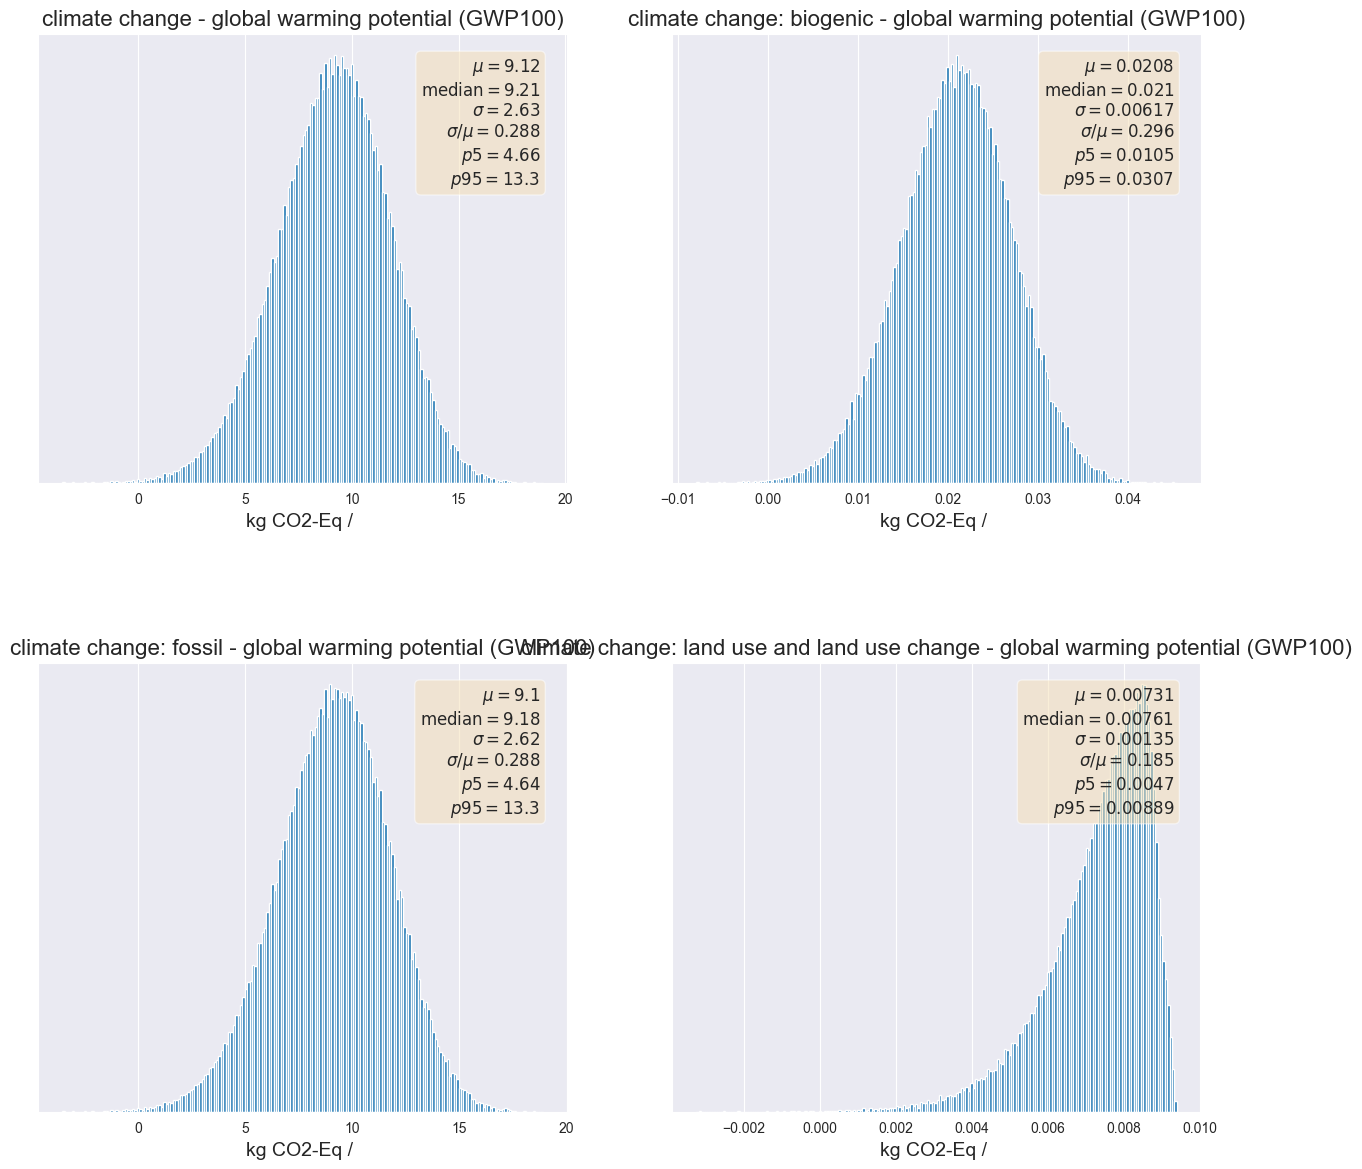

In [120]:
# Alternatively, graphs can be shown horizontally, together with a box of statistical outcomes
agb.distrib(
    total_inventory, impacts,
    functional_unit=functional_value,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2,
    percentiles=[5, 95])

In [121]:
# Full dashboard, including total variation of impacts 
agb.incer_stochastic_dashboard(
    model=total_inventory, 
    methods=impacts,
    functional_unit=functional_value)

[WARNING] Param 'b' is marked as FIXED, but passed in parameters : ignored


Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('EF v3.0', 'climate change', 'global warming potential (GWP100)')


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Processing sobol for ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: land use and land use change', 'global warming potential (GWP100)')


# Simplified model


In [123]:
# First, let's look at the full expression defining our model
expr, _ = agb.actToExpression(total_inventory)
expr

We provide some method to automatically select a subset of parameters, based on the **sobol indices**, and then compute simplified models for it.

We also round numerical expression to 3 digits, and we remove terms in sums that are less than 1% of total.

In [125]:
simplified = agb.sobol_simplify_model(
    total_inventory, # The model
    impacts, # Impacts to consider
    functional_unit=functional_value,
    
    n=10000, # For large model, you may test other value and ensure ST and sum(S1) are close to 1.0 
    fixed_mode = agb.FixedParamMode.MEDIAN, # We replace minor parameters by median by default,
    min_ratio=0.8, # Min ratio of variability to explain
    num_digits=3)

Generating samples ...


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Transforming samples ...


[WARNING] Param 'b' is marked as FIXED, but passed in parameters : ignored


Processing sobol for ('EF v3.0', 'climate change', 'global warming potential (GWP100)')


C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Processing sobol for ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: land use and land use change', 'global warming potential (GWP100)')
> Method :  climate change - global warming potential (GWP100)
S1:  0.9964605902284115
S2:  0.008170401886127663
ST:  1.0050527889083418
Selected params :  ['share_recycled_aluminium'] explains:  0.9732644015633352


> Method :  climate change: biogenic - global warming potential (GWP100)
S1:  0.9960982541044384
S2:  0.008486431796681324
ST:  1.005324201927781
Selected params :  ['share_recycled_aluminium'] explains:  0.9701141443946831


> Method :  climate change: fossil - global warming potential (GWP100)
S1:  0.9964600072846093
S2:  0.00817252787251606
ST:  1.005054389410038
Selected params :  ['share_recycled_aluminium'] explains:  0.9732350802781269


> Method :  climate change: land use and land use change - global warming potential (GWP100)
S1:  0.9947895481176297
S2:  0.004802548509361298
ST:  1.004606010053487
Selected params :  ['share_recycled_aluminium'] explains:  0.9875940272284827


In [126]:
# Let's look at the expression for first impact again 
# much simpler ! 
simplified[0].expr

Finally, we can compare the distribution of those simplified model against the full model. We provide a function for graphical display of it, and compuation of de R-Square score.


Generating samples ...
Transforming samples ...


[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
[INFO] Required param 'a' was missing, replacing by default value : 0.5
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\lca_algebraic\stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


Generating samples ...
Transforming samples ...


[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
[INFO] Required param 'a' was missing, replacing by default value : 0.5
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\lca_algebraic\stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


Generating samples ...
Transforming samples ...


[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
[INFO] Required param 'a' was missing, replacing by default value : 0.5
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\lca_algebraic\stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


Generating samples ...
Transforming samples ...


[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
[INFO] Required param 'a' was missing, replacing by default value : 0.5
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
C:\Users\mp_ma\anaconda3\envs\lca\lib\site-packages\lca_algebraic\stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


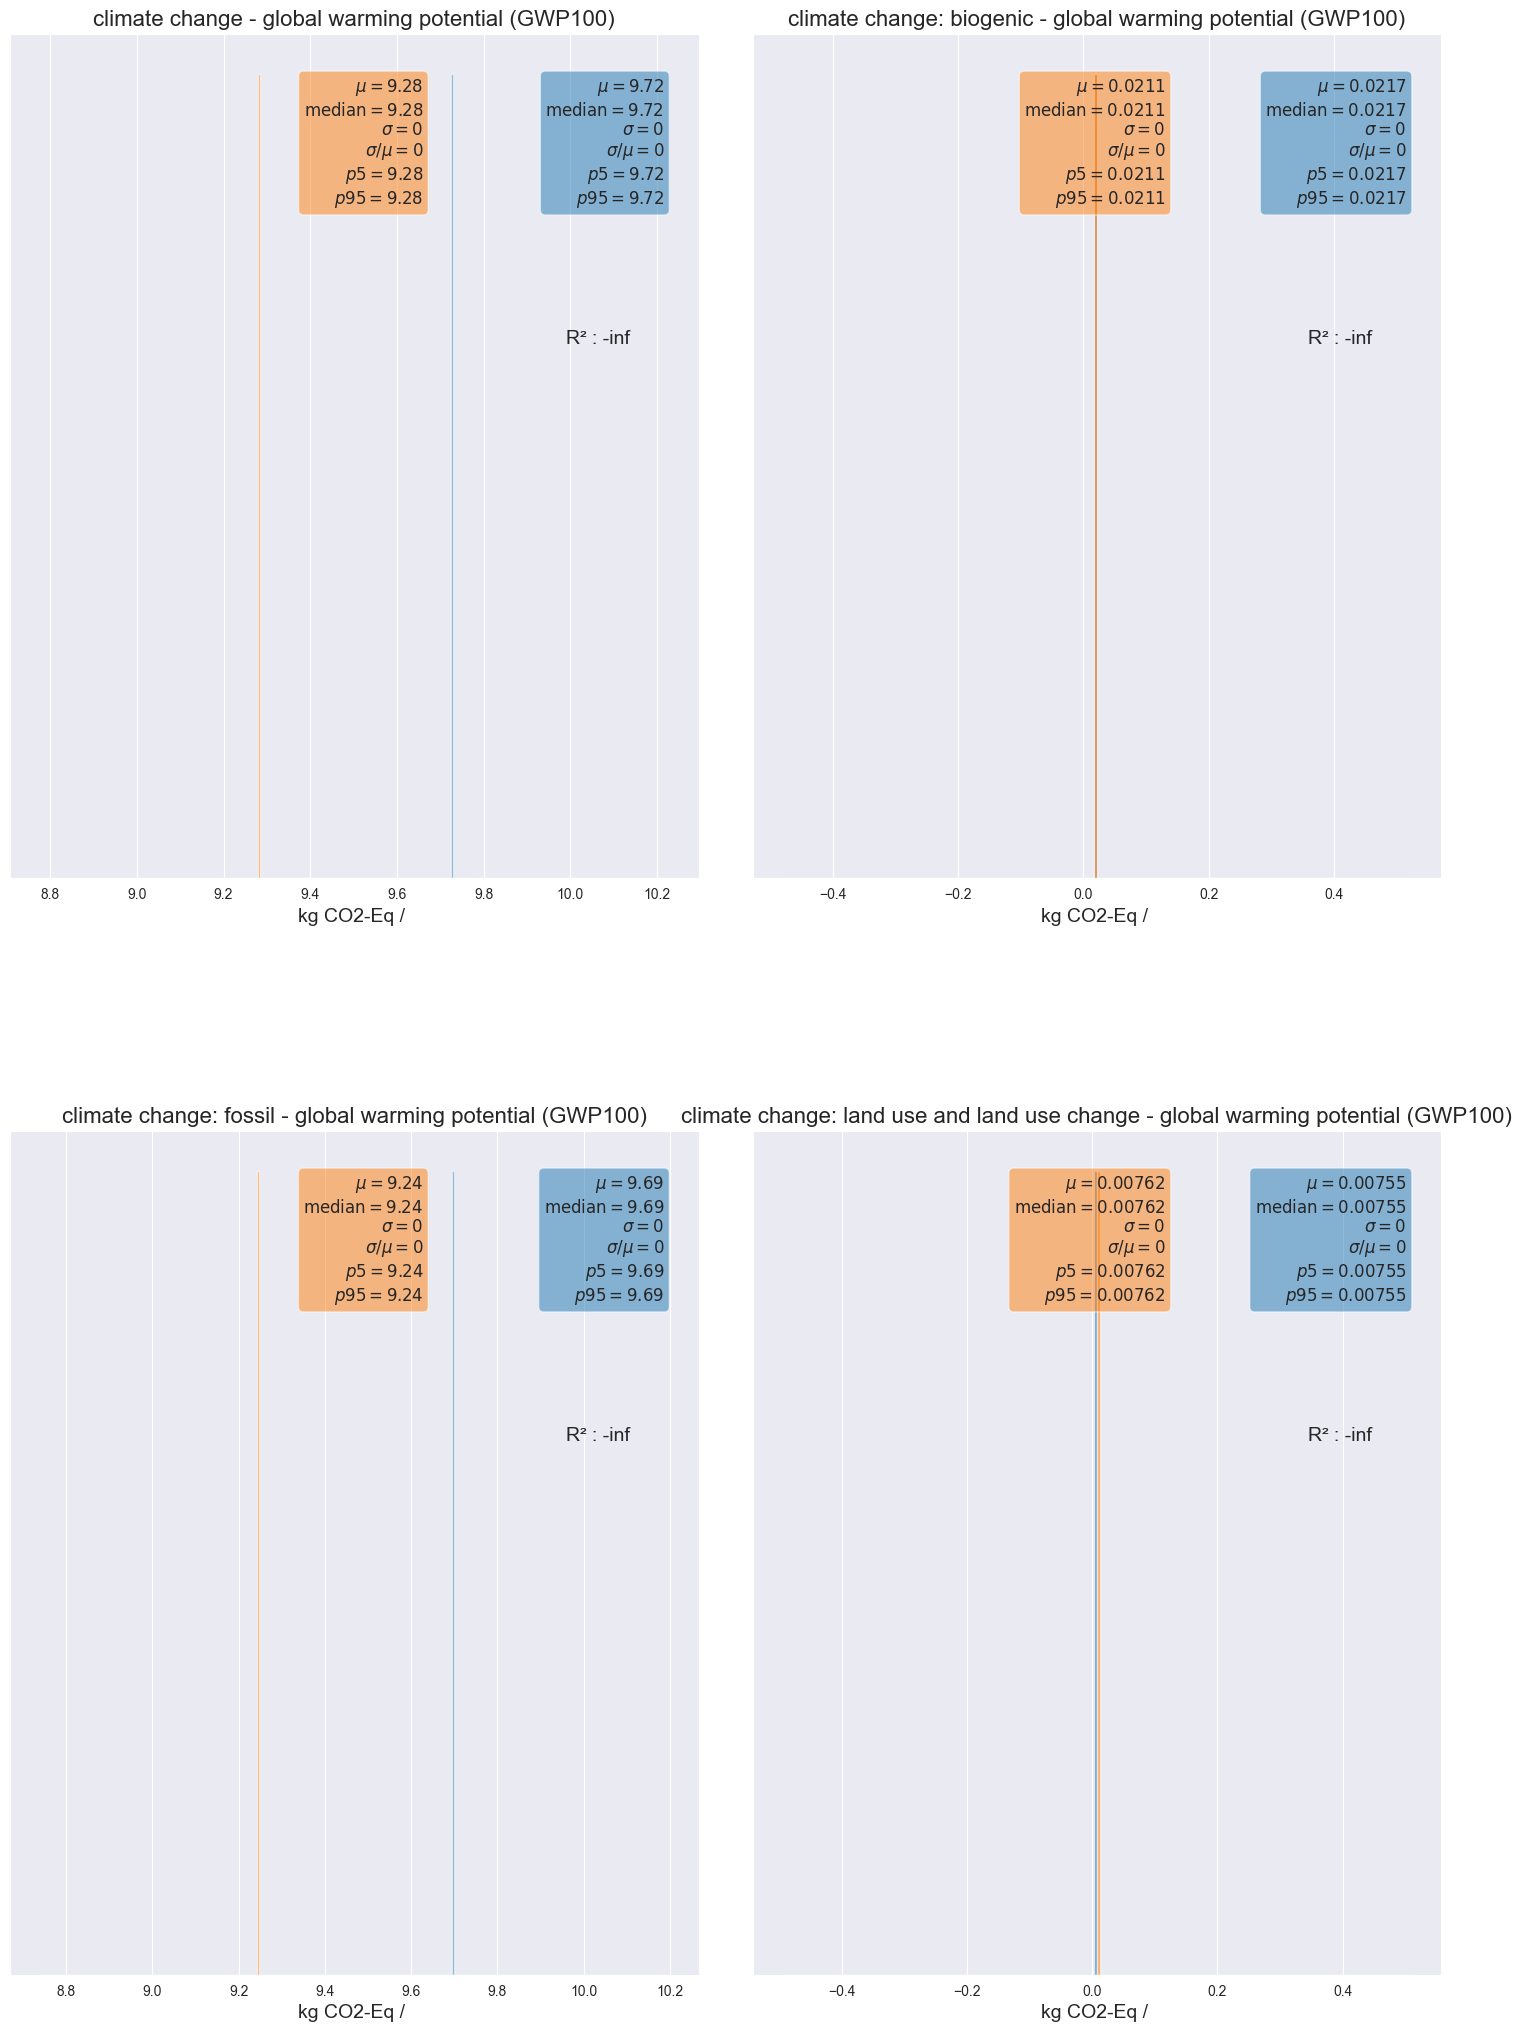

In [127]:
agb.compare_simplified(
    total_inventory, 
    impacts, 
    simplified,
    functional_unit=functional_value)

### Mining techniques

In [ ]:
mining_shares = {'open_pit':.161/.935,
                'underground':.200/.935,
                'ISL':0.574/.935}

### Mining energy mix

In [ ]:
mining_energy_shares = {'diesel':0.3,
                        'electricity':0.7}

In [ ]:
# Total energy for extraction : where does that come from ???

a_op = 274
b_op = -0.482

a_ug = 317
b_ug = -0.176

a_is = 220
b_is = -0.0485

extraction_energy_open_pit = a_op * exp(b_op * ore_grade) / recovery_rate
extraction_energy_underground = a_ug * exp(b_ug * ore_grade) / recovery_rate
extraction_energy_ISL = a_is * exp(b_is * ore_grade) / recovery_rate

In [ ]:
mining_electricity_switch = newEnumParam(
    'mining_electricity_switch', 
    label='Mining electricity, grid or diesel',
    values=['dieselgenerator',
            'grid'], # You can provide a statistical weight for each value, by using a dict
    default='dieselgenerator', 
    description="Choice of electricity source for mining",
    dbname=USER_DB)

### Emissions

In [12]:
# Emissions of radon-222 from tailings
tailings_Rn222 = newFloatParam(
    'tailings_Rn222', 
    default=0.01951, min=0.01, max=1,
    distrib=DistributionType.TRIANGLE, # Distribution type, linear by default
    description="Rn222 from tailings, in Bq/s",
    label="Rn222 from tailings, in Bq/s",
    unit='Bq/s',
    dbname=USER_DB)

NameError: name 'USER_DB' is not defined

## Concentration phase 

The following parameters are included:

- xxx


In [ ]:
# Conversion phase, heat consumption
conversion_heat = newFloatParam(
    'conversion_heat', 
    default=26, min=26, max=665,
    distrib=DistributionType.TRIANGLE,
    label='Conversion heat input',
    unit='kWh/kg U in UF6',
    description="Heat required to convert 1 kg of UF6",
    dbname=USER_DB)

## Refining stage 

### List of all parameters 

In [ ]:
list_parameters() # recap of all parameters declared in the model 

In [ ]:
# And because a figure is worth 1000 words
utils._plot_params([p for p in params._param_registry().all() if p.distrib in ['linear', 'triangle', 'lognormal']], columns=5, size=2000, figsize=(16,9))
plt.savefig('output/parameters.svg')

# Transforming and updating parametrized inventories

In [ ]:
# Mining and milling
tailings         = findActivity('Tailing, from uranium milling, WNA', loc='EUR', db_name='UNEP_IRP_EUR')
open_pit         = findActivity('Uranium mine operation, open cast, WNA', loc='GLO', db_name='UNEP_IRP_EUR')
underground      = findActivity('Uranium mine operation, underground, WNA', loc='GLO', db_name='UNEP_IRP_EUR')
ISL              = findActivity('Uranium mine operation, in-situ leaching, WNA', loc='GLO', db_name='UNEP_IRP_EUR')

In [ ]:
# Copy to preserve the non-parametrized inventories 
open_pit_p = copyActivity(
    USER_DB,
    open_pit,
    'Uranium mine operation, open cast, parameterized')

In [ ]:
# We replace fixed values by parameters in the LCI 
# Mining techniques, 3 activities
open_pit_p.updateExchanges({
    # This is electricity
    'market for diesel, burned in diesel-electric generating set, 10MW*': dict(amount=mining_energy_shares['electricity'] * extraction_energy_open_pit,
                                                                              input=mining_elec_mix),
    # This is diesel used as fuel
    'market for diesel, burned in building machine*': mining_energy_shares['diesel'] * extraction_energy_open_pit
}
)

In [ ]:
# Update inventories 